In [1]:
!pip install nibabel

In [2]:
!pip install nilearn

In [3]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.7 MB/s eta 0:00:0000:01


In [4]:
import os
import time
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import nibabel as nib
import nilearn as nl
import nilearn.plotting as nlplt

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from IPython.display import Image as show_gif

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage
from skimage.transform import rotate
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss

import warnings
warnings.simplefilter("ignore")

In [5]:
class GlobalConfig:
    root_dir = '/kaggle/input/brats20-dataset-training-validation'
    train_root_dir = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    test_root_dir = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
    path_to_csv = './train_data.csv'

    seed = 55

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

config = GlobalConfig()
seed_everything(config.seed)

In [6]:
survival_info_df = pd.read_csv('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv')
name_mapping_df = pd.read_csv('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv')

name_mapping_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True)


df = survival_info_df.merge(name_mapping_df, on="Brats20ID", how="right")

paths = []
for index, row  in df.iterrows():

    id_ = row['Brats20ID']
    phase = id_.split("_")[-2]

    if phase == 'Training':
        path = os.path.join(config.train_root_dir, id_)
    else:
        path = os.path.join(config.test_root_dir, id_)
    paths.append(path)

df['path'] = paths

train_data = df.loc[df['Age'].notnull()].reset_index(drop=True)
train_data = train_data.loc[train_data['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True, ) #eliminam pacientul 355 deoarece formatul nu este bun

# impartim data in antrenare (train), validare (val) si evaluare (test)
skf = StratifiedKFold(n_splits=7, random_state=config.seed, shuffle=True) #impartim setul de date in 7 parti folosind un seed pentru a obtine mereu aceeasi ordine
for i, (train_index, val_index) in enumerate(skf.split(train_data, train_data["Age"]//10*10)):
        train_data.loc[val_index, "fold"] = i

train_df = train_data.loc[train_data['fold'] != 0].reset_index(drop=True)
val_df = train_data.loc[train_data['fold'] == 0].reset_index(drop=True)

test_df = df.loc[~df['Age'].notnull()].reset_index(drop=True)
print("train_df ->", train_df.shape, "val_df ->", val_df.shape, "test_df ->", test_df.shape)
train_data.to_csv("train_data.csv", index=False)

train_df -> (201, 11) val_df -> (34, 11) test_df -> (133, 10)


In [7]:
def load_img1(file_path):
    data = nib.load(file_path)
    return data
tumor_core_total=0
peritumoral_edema_total=0
enhancing_tumor_total=0
num_zeros_total=0
for idx in train_data['Brats20ID']:
    root_path = train_data.loc[train_data['Brats20ID'] == idx]['path'].values[0] 
    img_path = os.path.join(root_path +'/' + idx+  '_seg.nii')
    img = load_img1(img_path)
    a = np.array(img.dataobj)
    b=a.flatten()

    tumor_core=np.count_nonzero(b == 1)
    tumor_core_total=tumor_core_total+tumor_core

    peritumoral_edema=np.count_nonzero(b==2)
    peritumoral_edema_total=peritumoral_edema_total+peritumoral_edema

    enhancing_tumor=np.count_nonzero(b==4)
    enhancing_tumor_total=enhancing_tumor_total+enhancing_tumor

    num_zeros = (b == 0).sum()
    num_zeros_total=num_zeros_total+num_zeros
print(tumor_core_total)
print(peritumoral_edema_total)
print(enhancing_tumor_total)
print(num_zeros_total)
print(tumor_core_total+peritumoral_edema_total+enhancing_tumor_total+num_zeros_total)

2877451
13244475
5250041
2076708033
2098080000


In [8]:
def get_center_crop_coords(height, width, depth, crop_height, crop_width, crop_depth):
                x1 = (height - crop_height) // 2
                x2 = x1 + crop_height
                y1 = (width - crop_width) // 2
                y2 = y1 + crop_width
                z1 = (depth - crop_depth) // 2
                z2 = z1 + crop_depth
                return x1, y1, z1, x2, y2, z2

def center_crop(data:np.ndarray, crop_height, crop_width, crop_depth):
    height, width, depth = data.shape[:3]
    if height < crop_height or width < crop_width or depth < crop_depth:
        raise ValueError
    x1, y1, z1, x2, y2, z2 = get_center_crop_coords(height, width, depth, crop_height, crop_width, crop_depth)
    data = data[x1:x2, y1:y2, z1:z2]
    return data

def load_img1(file_path):
    data = nib.load(file_path)
    return data
tumor_core_total=0
peritumoral_edema_total=0
enhancing_tumor_total=0
num_zeros_total=0
for idx in train_data['Brats20ID']:
    root_path = train_data.loc[train_data['Brats20ID'] == idx]['path'].values[0] 
    img_path = os.path.join(root_path +'/' + idx+  '_seg.nii')
    img = load_img1(img_path)
    a = np.array(img.dataobj)
    get_center_crop_coords(240,240,155, 128,128,128)
    a=center_crop(a, 128,128,128)
    b=a.flatten()

    tumor_core=np.count_nonzero(b == 1)
    tumor_core_total=tumor_core_total+tumor_core

    peritumoral_edema=np.count_nonzero(b==2)
    peritumoral_edema_total=peritumoral_edema_total+peritumoral_edema

    enhancing_tumor=np.count_nonzero(b==4)
    enhancing_tumor_total=enhancing_tumor_total+enhancing_tumor

    num_zeros = (b == 0).sum()
    num_zeros_total=num_zeros_total+num_zeros
print(tumor_core_total)
print(peritumoral_edema_total)
print(enhancing_tumor_total)
print(num_zeros_total)
print(tumor_core_total+peritumoral_edema_total+enhancing_tumor_total+num_zeros_total)

2806199
12718614
5020216
472285691
492830720


In [9]:
def load_img1(file_path):
    data = nib.load(file_path)
    return data
tumor_core_total=0
peritumoral_edema_total=0
enhancing_tumor_total=0
num_zeros_total=0
for idx in val_df['Brats20ID']:
    root_path = val_df.loc[val_df['Brats20ID'] == idx]['path'].values[0] # preluam calea din fisierul csv
    img_path = os.path.join(root_path +'/' + idx+  '_seg.nii')
    img = load_img1(img_path)
    a = np.array(img.dataobj)
    b=a.flatten()
#     unique, counts = np.unique(b, return_counts=True)
#     dict(zip(unique, counts))
    tumor_core=np.count_nonzero(b == 1)
    tumor_core_total=tumor_core_total+tumor_core

    peritumoral_edema=np.count_nonzero(b==2)
    peritumoral_edema_total=peritumoral_edema_total+peritumoral_edema

    enhancing_tumor=np.count_nonzero(b==4)
    enhancing_tumor_total=enhancing_tumor_total+enhancing_tumor

    num_zeros = (b == 0).sum()
    num_zeros_total=num_zeros_total+num_zeros
print(tumor_core_total)
print(peritumoral_edema_total)
print(enhancing_tumor_total)
print(num_zeros_total)

472090
1887772
814903
300377235


In [10]:
from monai.transforms import (
    Compose,
    RandAffined,
    RandGaussianNoised,
    EnsureChannelFirstd,
    ScaleIntensityd,
    RandFlipd,
    RandRotate90d,
    ToTensord
)

# Define MONAI transforms for 3D data
train_transforms = Compose([
    #EnsureChannelFirstd(keys=['image', 'mask']),  # Ensure data has channel dimension
    ScaleIntensityd(keys=['image']),  # Normalize intensity values
    RandAffined(
        keys=['image', 'mask'],
        mode=('bilinear', 'nearest'),  # Use bilinear for image, nearest for mask
        prob=0.5,
        spatial_size=(128, 128, 128),  # Output size
        rotate_range=(0, 0, np.pi/15),  # Random rotation
        scale_range=(0.1, 0.1, 0.1)  # Random scaling
    ),
    RandGaussianNoised(keys=['image'], prob=0.5, std=0.01),  # Add Gaussian noise
    RandFlipd(keys=['image', 'mask'], prob=0.5, spatial_axis=0),  # Random flip
    RandRotate90d(keys=['image', 'mask'], prob=0.5, max_k=3),  # Random 90-degree rotation
    ToTensord(keys=['image', 'mask'])  # Convert to PyTorch tensors
])

class BratsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str="test", transform=None):
        self.df = df
        self.phase = phase
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        if transform is None:
            self.transform = train_transforms if phase == "train" else Compose([])
        else:
            self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        
        # Load and preprocess image volumes
        images = []
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)
            img = self.center_crop(img, 128, 128, 128)
            img = self.normalize(img)
            images.append(img)
            
        # Stack modalities to create 4D tensor (4, 128, 128, 128)
        img = np.stack(images)  # Shape: (4, 128, 128, 128) = (C, H, W, D)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
        img=img.astype(np.float32)

        if self.phase != "test":
            # Load and preprocess mask
            mask_path = os.path.join(root_path, id_ + "_seg.nii")
            mask = self.load_img(mask_path)
            mask = self.center_crop(mask, 128, 128, 128)
            mask = self.preprocess_mask_labels(mask)  # Shape: (3, 128, 128, 128)
            mask = mask.astype(np.float32)
            aug_img, aug_mask = img, mask 

            # Apply MONAI transforms
            
            data = {'image': img, 'mask': mask}
            transformed = self.transform(data)
            aug_img = transformed['image']
            aug_mask = transformed['mask']

            return {
                "Id": id_,
                "image": img,
                "mask": mask,
                "aug_image": aug_img,
                "aug_mask": aug_mask,
            }

        return {
            "Id": id_,
            "image": torch.from_numpy(img),
        }

    # Keep other helper methods the same
    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data

    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)

    def get_center_crop_coords(self, height, width, depth, crop_height, crop_width, crop_depth):
        x1 = (height - crop_height) // 2
        x2 = x1 + crop_height
        y1 = (width - crop_width) // 2
        y2 = y1 + crop_width
        z1 = (depth - crop_depth) // 2
        z2 = z1 + crop_depth
        return x1, y1, z1, x2, y2, z2

    def center_crop(self, data: np.ndarray, crop_height, crop_width, crop_depth):
        height, width, depth = data.shape[:3]
        if height < crop_height or width < crop_width or depth < crop_depth:
            raise ValueError
        x1, y1, z1, x2, y2, z2 = self.get_center_crop_coords(height, width, depth, crop_height, crop_width, crop_depth)
        data = data[x1:x2, y1:y2, z1:z2]
        return data
        
    def preprocess_mask_labels(self, mask: np.ndarray):
        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1  # Label 1 = necrotic / non-enhancing tumor core
        mask_WT[mask_WT == 2] = 1  # Label 2 = peritumoral edema
        mask_WT[mask_WT == 4] = 1  # Label 4 = enhancing tumor core

        mask_TC = mask.copy()
        mask_TC[mask_TC == 1] = 1
        mask_TC[mask_TC == 2] = 0
        mask_TC[mask_TC == 4] = 1

        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))  # Reorder axes for visualization
        return mask

In [11]:
def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 4,
    transform = None,
    
):

    df = pd.read_csv(path_to_csv)

    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    df = train_df if phase == "train" else val_df
        # Handle dataset splitting

    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=False,
    )
    return dataloader


train_dataloader = get_dataloader(BratsDataset, "train_data.csv", phase="train", transform=train_transforms)
val_dataloader = get_dataloader(BratsDataset, "train_data.csv", phase="valid", transform=None, fold = 0)


In [12]:
data = next(iter(train_dataloader))

# Print basic info
print("ID:", data['Id'])
print("Original Image Shape:", data['image'].shape)
print("Original Mask Shape:", data['mask'].shape)
print("Augmented Image Shape:", data['aug_image'].shape)
print("Augmented Mask Shape:", data['aug_mask'].shape)

# Convert masks to numpy for visualization
original_mask = data['mask'].squeeze()[0].cpu().detach().numpy()
augmented_mask = data['aug_mask'].squeeze()[0].cpu().detach().numpy()

# Print unique values in original and augmented masks
print("Original Mask Values:", np.unique(original_mask, return_counts=True))
print("Augmented Mask Values:", np.unique(augmented_mask, return_counts=True))
print("Original Mask Tensor (Slice 60):", original_mask[60].astype(int))
print("Augmented Mask Tensor (Slice 60):", augmented_mask[60].astype(int))

ID: ['BraTS20_Training_001']
Original Image Shape: torch.Size([1, 4, 128, 128, 128])
Original Mask Shape: torch.Size([1, 3, 128, 128, 128])
Augmented Image Shape: torch.Size([1, 4, 128, 128, 128])
Augmented Mask Shape: torch.Size([1, 3, 128, 128, 128])
Original Mask Values: (array([0., 1.], dtype=float32), array([1886119,  211033]))
Augmented Mask Values: (array([0., 1.], dtype=float32), array([1851489,  245663]))
Original Mask Tensor (Slice 60): [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Augmented Mask Tensor (Slice 60): [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


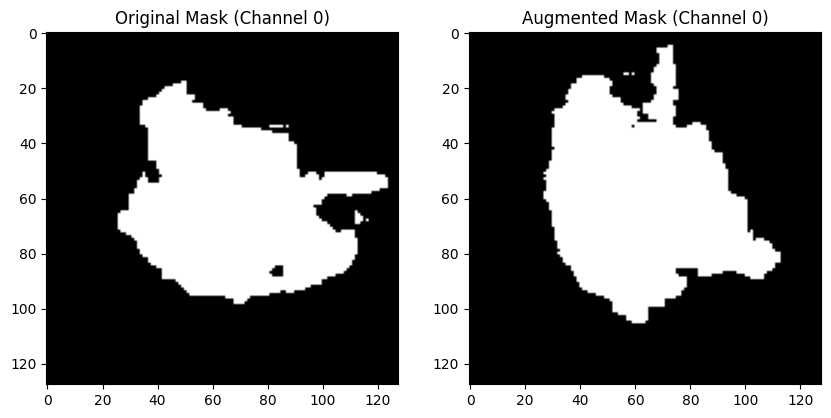

In [13]:
import matplotlib.pyplot as plt  

slice_idx = 40  # Choose a relevant slice  
channel_idx = 0  # Choose which tumor label to visualize  

original_mask = data['mask'][0, channel_idx, :, :, slice_idx].cpu().numpy()  
augmented_mask = data['aug_mask'][0, channel_idx, :, :, slice_idx].cpu().numpy()  

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  
axes[0].imshow(original_mask, cmap='gray')  
axes[0].set_title("Original Mask (Channel 0)")  
axes[1].imshow(augmented_mask, cmap='gray')  
axes[1].set_title("Augmented Mask (Channel 0)")  
plt.show()

In [14]:
def accuracy_coef_metric(probabilities: torch.Tensor,
                    truth: torch.Tensor,
                    threshold: float = 0.5, 
                    eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= threshold).float()
    assert predictions.shape == truth.shape

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]

        correct = (prediction == truth_).sum().item()
        total = truth_.numel()

        scores.append(correct / total)

    return np.mean(scores)


def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:

    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

def jaccard_coef_metric(probabilities: torch.Tensor,truth: torch.Tensor, treshold: float = 0.5, eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

def sen_coef_metric(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9) -> np.ndarray:

    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (truth_ * prediction).sum()
        union = truth_.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
                scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def spf_coef_metric(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9) -> np.ndarray:

    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]

        TN = ((prediction == 0) & (truth_ == 0)).sum().float()  # True Negatives
        FP = ((prediction == 1) & (truth_ == 0)).sum().float()  # False Positives

        specificity = (TN + eps) / (TN + FP + eps)  # Compute specificity
        scores.append(specificity.item())  # Convert to Python scalar for numpy compatibility

    return np.mean(scores)  # Return mean specificity as a NumPy scalar


class Meter:
    # stocam si actualizam dice score-ul
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []
        self.sen_scores: list=[]
        self.spf_scores: list=[]
        self.acc_scores: list = []  # New accuracy list


    def update(self, logits: torch.Tensor, targets: torch.Tensor):
      
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)
        sen = sen_coef_metric(probs, targets, self.threshold)
        spf = spf_coef_metric(probs, targets, self.threshold)
        acc = accuracy_coef_metric(probs, targets, self.threshold) 
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
        self.sen_scores.append(sen)
        self.spf_scores.append(spf)
        self.acc_scores.append(acc)  

    def get_metrics(self) -> np.ndarray:
        # returneaza media scorurilor
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        sen = np.mean(self.sen_scores)
        spf = np.mean(self.spf_scores)
        acc = np.mean(self.acc_scores)  
        return dice, iou, sen, spf, acc


class DiceLoss(nn.Module):
    # calculeaza dice loss-ul
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:

        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)

        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        return 1.0 - dice_score

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)

        return bce_loss + dice_loss


def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:

    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores



def sen_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:

    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (truth_ * prediction).sum()
            union = truth_.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

def spf_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:

    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (truth_ * prediction).sum()
            union = prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
    return scores

def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:

    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

IR-ViT-MSF

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops.layers.torch import Rearrange
from torch.cuda.amp import autocast

# 3D Inception-Residual Block
class InceptionResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1x1 = nn.Conv3d(in_channels, out_channels // 4, kernel_size=1, padding=0)
        self.conv3x3 = nn.Conv3d(in_channels, out_channels // 4, kernel_size=3, padding=1)
        self.conv5x5 = nn.Conv3d(in_channels, out_channels // 4, kernel_size=5, padding=2)
        self.conv7x7 = nn.Conv3d(in_channels, out_channels // 4, kernel_size=7, padding=3)
        self.residual = nn.Conv3d(in_channels, out_channels, kernel_size=1, padding=0)
        self.bn = nn.InstanceNorm3d(out_channels)

    def forward(self, x):
        out = torch.cat([self.conv1x1(x), self.conv3x3(x), self.conv5x5(x), self.conv7x7(x)], dim=1)
        out = self.bn(out + self.residual(x))
        return F.relu(out)

# 3D Vision Transformer Encoder Block
class ViTBlock(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

# Multi-Scale Fusion Module
class MultiScaleFusion(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1)
        self.up = nn.ConvTranspose3d(in_channels, in_channels, kernel_size=2, stride=2)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return F.relu(self.conv(x))

# The Hybrid ViT-CNN-PCR Model
class ViT_CNN_Segmentation(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.enc1 = InceptionResBlock(4, 32)
        self.enc2 = InceptionResBlock(32, 64)
        self.enc3 = InceptionResBlock(64, 128)
        self.enc4 = InceptionResBlock(128, 128)  # Adjusted to 128 channels
        
        # Transformer Bottleneck
        self.flatten = Rearrange('b c d h w -> b (d h w) c')
        self.vit = ViTBlock(128, num_heads=8)
        self.unflatten = Rearrange('b (d h w) c -> b c d h w', d=16, h=16, w=16)
        
        # Decoder
        self.dec3 = MultiScaleFusion(128, 128, 128)
        self.dec2 = MultiScaleFusion(128, 64, 64)
        self.dec1 = MultiScaleFusion(64, 32, 32)
        
        # Output layer
        self.out_conv = nn.Conv3d(32, 3, kernel_size=1)

    def forward(self, x):
        # Encoding
        x1 = self.enc1(x)
        x2 = self.enc2(F.max_pool3d(x1, 2))
        x3 = self.enc3(F.max_pool3d(x2, 2))
        x4 = self.enc4(F.max_pool3d(x3, 2))
        
        # Transformer
        vit_features = self.vit(self.flatten(x4))
        vit_features = self.unflatten(vit_features)
        
        # Decoding
        x = self.dec3(vit_features, x3)
        x = self.dec2(x, x2)
        x = self.dec1(x, x1)
        
        return self.out_conv(x)



In [16]:
!pip install seaborn

In [17]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [18]:
import seaborn as sns
class Trainer:
    def __init__(self,
                 net: nn.Module,
                 dataset: torch.utils.data.Dataset,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 display_plot: bool = True,
                ):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=4, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs

        # Initialize fresh dataloaders
        self.dataloaders = {
            phase: get_dataloader(
                dataset=dataset,
                path_to_csv=path_to_csv,
                phase=phase,
                fold=fold,
                batch_size=batch_size,
                num_workers=4,
                #augment_prob= 0.1,  # Probability of applying augmentations
            )
            for phase in self.phases
        }

        # Ensure fresh training: Reset best loss and training logs
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}
        self.sen_scores = {phase: [] for phase in self.phases}
        self.spf_scores = {phase: [] for phase in self.phases}
        self.acc_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self, images: torch.Tensor, targets: torch.Tensor):
        images, targets = images.to(self.device), targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")
        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()

       # Progress bar using tqdm
        with tqdm(total=total_batches, desc=f"{phase.upper()} {epoch+1}", unit="batch") as pbar:
            for itr, data_batch in enumerate(dataloader):
                images, targets = data_batch['image'], data_batch['mask']
                loss, logits = self._compute_loss_and_outputs(images, targets)
                loss = loss / self.accumulation_steps

                if phase == "train":
                    loss.backward()
                    if (itr + 1) % self.accumulation_steps == 0:
                        self.optimizer.step()
                        self.optimizer.zero_grad()

                running_loss += loss.item()
                meter.update(logits.detach().cpu(), targets.detach().cpu())

                # Update progress bar with loss
                pbar.set_postfix(loss=f"{loss.item():.4f}")
                pbar.update(1)

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou, epoch_sen, epoch_spf, epoch_acc = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)
        self.sen_scores[phase].append(epoch_sen)
        self.spf_scores[phase].append(epoch_spf)
        self.acc_scores[phase].append(epoch_acc)

        return epoch_loss

    def run(self):
        print("Starting training from scratch...")

        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)

            # Save best model
            if val_loss < self.best_loss:
                print(f"\n{'#' * 20}\nSaved new checkpoint\n{'#' * 20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")

            print()
        
        if self.display_plot:
            self._plot_train_history()

        self._save_train_history()

    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores, self.acc_scores, self.sen_scores, self.spf_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,

            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]}
            """,

            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,

            f"""
            train acc score {self.acc_scores['train'][-1]}
            val acc score {self.acc_scores['val'][-1]}
            """,

            f"""
            train sen score {self.sen_scores['train'][-1]}
            val sen score {self.sen_scores['val'][-1]}
            """,

            f"""
            train spf score {self.spf_scores['train'][-1]}
            val spf score {self.spf_scores['val'][-1]}
            """,
        ]

        with plt.style.context("seaborn-dark-palette"):
        # Dynamically calculate the number of rows and columns
            num_plots = len(data)
            num_cols = 3  # Number of columns
            num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate rows dynamically

            # Create subplots
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 10 * num_rows))
            axes = axes.flatten()  # Flatten the 2D array into 1D

            # Plot each metric
            for i in range(num_plots):
                
                ax = axes[i]
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")

            # Hide unused subplots
            for i in range(num_plots, num_rows * num_cols):
               
                axes[i].axis('off')

            plt.tight_layout()
            plt.show()

        """"with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(6, 3, figsize=(30, 30))
            axes = axes.flatten() 
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")
                
            plt.tight_layout()
            plt.show()"""

    def _save_train_history(self):
        print("Saving final model and logs...")
        torch.save(self.net.state_dict(), "final_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores, self.acc_scores, self.sen_scores, self.spf_scores]
        log_names_ = ["_loss", "_dice", "_jaccard","_acc", "_sen", "_spf"]
        logs = [logs_[i][key] for i in range(len(logs_)) for key in logs_[i]]
        log_names = [key + log_names_[i] for i in range(len(logs_)) for key in logs_[i]]

        pd.DataFrame(dict(zip(log_names, logs))).to_csv("train_log.csv", index=False)

In [ ]:
nodel=ViT_CNN_Segmentation()
print(nodel)
sum([param.nelement() for param in nodel.parameters()])

In [ ]:
trainer = Trainer(
    net=nodel,
    dataset=BratsDataset,
    criterion=BCEDiceLoss(),
    lr=1e-4,
    accumulation_steps=4,
    batch_size=1,
    fold=0,
    num_epochs=100,
    path_to_csv=config.path_to_csv
)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
%%time
trainer.run()

In [ ]:
def compute_scores_per_classes(model,
                               dataloader,
                               classes):
    # coeficientii dice pentru fiecare clasă
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}
    sen_scores_per_classes = {key: list() for key in classes}
    spf_scores_per_classes = {key: list() for key in classes}


    with torch.no_grad(): # pentru setul de validare nu vrem sa mai învețe modelul
        for i, data in enumerate(dataloader):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()

            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)
            sen_scores = sen_coef_metric_per_classes(logits, targets)
            spf_scores = spf_coef_metric_per_classes(logits, targets)

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

            for key in sen_scores.keys():
                sen_scores_per_classes[key].extend(sen_scores[key])

            for key in spf_scores.keys():
                spf_scores_per_classes[key].extend(spf_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes, sen_scores_per_classes, spf_scores_per_classes

In [ ]:
val_dataloader = get_dataloader(BratsDataset, 'train_data.csv', phase='valid', fold=0)
len(val_dataloader)


In [ ]:
nodel.eval();

In [ ]:
%%time
dice_scores_per_classes, iou_scores_per_classes, sen_scores_per_classes, spf_scores_per_classes = compute_scores_per_classes(nodel, val_dataloader, ['WT', 'TC', 'ET'])

In [ ]:
# dice_df = pd.DataFrame(dice_scores_per_classes)
# dice_df.columns = ['WT dice', 'TC dice', 'ET dice']
# print(dice_df.head(5))
# val_metics_df = dice_df.loc[:, ['WT dice', 'TC dice', 'ET dice']]
# print(val_metics_df)
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT iou', 'TC iou', 'ET iou']

sen_df = pd.DataFrame(sen_scores_per_classes)
sen_df.columns = ['WT sen', 'TC sen', 'ET sen']

spf_df = pd.DataFrame(spf_scores_per_classes)
spf_df.columns = ['WT spf', 'TC spf', 'ET spf']

val_metics_df = pd.concat([dice_df, iou_df, sen_df, spf_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT iou', 'WT sen','WT spf',
                                      'TC dice', 'TC iou', 'TC sen', 'TC spf',
                                      'ET dice', 'ET iou', 'ET sen', 'ET spf']]
val_metics_df.sample(5)

In [ ]:
colors = ['royalblue', 'royalblue','royalblue', 'royalblue', 'lightcoral', 'lightcoral','lightcoral','lightcoral', 'greenyellow', 'greenyellow', 'greenyellow', 'greenyellow']
palette = sns.color_palette(colors, 12)

fig, ax = plt.subplots(figsize=(20, 20));
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_metics_df.columns, fontsize=16);
ax.set_title("Coefficient scores", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=16)

In [ ]:
def compute_results(model,
                    dataloader,
                    treshold=0.33):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results = {"Id": [],"image": [], "GT": [],"Prediction": []}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            id_, imgs, targets = data['Id'], data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits)

            predictions = (probs >= treshold).float()
            predictions =  predictions.cpu()
            targets = targets.cpu()

            results["Id"].append(id_)
            results["image"].append(imgs.cpu())
            results["GT"].append(targets)
            results["Prediction"].append(predictions)

            # only 5 pars
            if (i > 10):
                return results
            print(results['Id'])
        return results

In [ ]:
%%time
results = compute_results(nodel, val_dataloader, 0.33)

In [ ]:
for id_, img, gt, prediction in zip(results['Id'],
                    results['image'],
                    results['GT'],
                    results['Prediction']
                    ):

    print(id_)

In [ ]:
from skimage.util import montage
import numpy as np
import matplotlib.pyplot as plt

class ShowResult:
    def mask_preprocessing(self, mask):
        """
        Processes segmentation masks for visualization.
        """
        mask = mask.squeeze().cpu().detach().numpy()
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))  # Ensure correct ordering

        mask_WT = np.rot90(montage(mask[0]))  # Whole Tumor
        mask_TC = np.rot90(montage(mask[1]))  # Tumor Core
        mask_ET = np.rot90(montage(mask[2]))  # Enhancing Tumor

        return mask_WT, mask_TC, mask_ET

    def image_preprocessing(self, image):
        """
        Extracts FLAIR and T2 images for visualization.
        """
        image = image.squeeze().cpu().detach().numpy()
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))  # (C, D, H, W) -> (C, H, W, D)

        flair_img = np.rot90(montage(image[0]))  # Assuming Channel 0 is FLAIR
        t2_img = np.rot90(montage(image[1]))  # Assuming Channel 1 is T2

        return flair_img, t2_img

    def plot(self, image, ground_truth, prediction):
        """
        Plots FLAIR, T2, ground truth, and prediction segmentations with larger plots (2 per row).
        """
        flair_img, t2_img = self.image_preprocessing(image)
        gt_mask_WT, gt_mask_TC, gt_mask_ET = self.mask_preprocessing(ground_truth)
        pr_mask_WT, pr_mask_TC, pr_mask_ET = self.mask_preprocessing(prediction)

        fig, axes = plt.subplots(3, 2, figsize=(20, 30))  # 3 rows, 2 columns (larger images)
        [ax.axis("off") for ax in axes.ravel()]  

        # FLAIR Image
        axes[0, 0].set_title("FLAIR Image", fontsize=20, weight='bold')
        axes[0, 0].imshow(flair_img, cmap='bone')

        # T2 Image
        axes[0, 1].set_title("T2 Image", fontsize=20, weight='bold')
        axes[0, 1].imshow(t2_img, cmap='bone')

        # Ground Truth Segmentation
        axes[1, 0].set_title("Ground Truth", fontsize=20, weight='bold')
        axes[1, 0].imshow(flair_img, cmap='bone')  # Overlay GT on FLAIR
        axes[1, 0].imshow(np.ma.masked_where(gt_mask_WT == 0, gt_mask_WT), cmap='cool_r', alpha=0.6)
        axes[1, 0].imshow(np.ma.masked_where(gt_mask_TC == 0, gt_mask_TC), cmap='YlGnBu', alpha=0.6)
        axes[1, 0].imshow(np.ma.masked_where(gt_mask_ET == 0, gt_mask_ET), cmap='cool', alpha=0.6)

        # Prediction Segmentation
        axes[1, 1].set_title("Prediction", fontsize=20, weight='bold')
        axes[1, 1].imshow(flair_img, cmap='bone')  # Overlay Prediction on FLAIR
        axes[1, 1].imshow(np.ma.masked_where(pr_mask_WT == 0, pr_mask_WT), cmap='cool_r', alpha=0.6)
        axes[1, 1].imshow(np.ma.masked_where(pr_mask_TC == 0, pr_mask_TC), cmap='autumn_r', alpha=0.6)
        axes[1, 1].imshow(np.ma.masked_where(pr_mask_ET == 0, pr_mask_ET), cmap='autumn', alpha=0.6)

        plt.tight_layout()
        plt.show()
show_result = ShowResult()
for id_, img, gt, prediction in zip(results['Id'], results['image'], results['GT'], results['Prediction']):
    print(f"Displaying results for ID: {id_}")
    show_result.plot(img, gt, prediction)

In [ ]:
#SINGLE SLICE 64TH
from skimage.util import montage
import numpy as np
import matplotlib.pyplot as plt

class ShowResult:
    def __init__(self, slice_idx=64):
        """
        Initialize with the desired slice index (default is 64).
        """
        self.slice_idx = slice_idx

    def mask_preprocessing(self, mask):
        """
        Processes segmentation masks for visualization, extracting the specified slice.
        """
        mask = mask.squeeze().cpu().detach().numpy()
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))  # Ensure correct ordering

        # Extract the specified slice
        mask_WT = mask[0, :, :, self.slice_idx]  # Whole Tumor
        mask_TC = mask[1, :, :, self.slice_idx]  # Tumor Core
        mask_ET = mask[2, :, :, self.slice_idx]  # Enhancing Tumor

        return mask_WT, mask_TC, mask_ET

    def image_preprocessing(self, image):
        """
        Extracts FLAIR and T2 images for visualization, extracting the specified slice.
        """
        image = image.squeeze().cpu().detach().numpy()
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))  # (C, D, H, W) -> (C, H, W, D)

        # Extract the specified slice
        flair_img = image[0, :, :, self.slice_idx]  # Assuming Channel 0 is FLAIR
        t2_img = image[1, :, :, self.slice_idx]  # Assuming Channel 1 is T2

        return flair_img, t2_img

    def plot(self, image, ground_truth, prediction):
        """
        Plots FLAIR, T2, ground truth, and prediction segmentations for the specified slice.
        """
        flair_img, t2_img = self.image_preprocessing(image)
        gt_mask_WT, gt_mask_TC, gt_mask_ET = self.mask_preprocessing(ground_truth)
        pr_mask_WT, pr_mask_TC, pr_mask_ET = self.mask_preprocessing(prediction)
        black_bg = np.zeros((240, 240))
        fig, axes = plt.subplots(1, 4, figsize=(10, 15))  # 3 rows, 2 columns (larger images)
        [ax.axis("off") for ax in axes.ravel()]  

        # FLAIR Image
        axes[0].set_title("FLAIR Image", fontsize=14, weight='bold')
        axes[0].imshow(flair_img, cmap='bone')

        # T2 Image
        axes[1].set_title("T2 Image", fontsize=14, weight='bold')
        axes[1].imshow(t2_img, cmap='bone')

        # Ground Truth Segmentation
        axes[2].set_title("Ground Truth", fontsize=14, weight='bold')
        axes[2].imshow(flair_img, cmap='bone')  # Overlay GT on FLAIR
        #axes[2].imshow(black_bg, cmap='gray', vmin=0, vmax=1)
        axes[2].imshow(np.ma.masked_where(gt_mask_WT == 0, gt_mask_WT), cmap='cool_r', alpha=1.0)
        axes[2].imshow(np.ma.masked_where(gt_mask_TC == 0, gt_mask_TC), cmap='autumn_r', alpha=1.0)
        axes[2].imshow(np.ma.masked_where(gt_mask_ET == 0, gt_mask_ET), cmap='autumn', alpha=1.0)

        # Prediction Segmentation
        axes[3].set_title("Prediction", fontsize=14, weight='bold')
        axes[3].imshow(flair_img, cmap='bone')  # Overlay Prediction on FLAIR
        axes[3].imshow(np.ma.masked_where(pr_mask_WT == 0, pr_mask_WT), cmap='cool_r', alpha=1.0)
        axes[3].imshow(np.ma.masked_where(pr_mask_TC == 0, pr_mask_TC), cmap='autumn_r', alpha=1.0)
        axes[3].imshow(np.ma.masked_where(pr_mask_ET == 0, pr_mask_ET), cmap='autumn', alpha=1.0)

        plt.tight_layout()
        plt.show()

# Initialize with the desired slice index (e.g., 64)
show_result = ShowResult(slice_idx=64)

# Iterate through results and plot
for id_, img, gt, prediction in zip(results['Id'], results['image'], results['GT'], results['Prediction']):
    print(f"Displaying results for ID: {id_}")
    show_result.plot(img, gt, prediction)

**EXTERNAL VALIDATION **

In [ ]:
import os
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import MSELoss
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
model =  AttentionUNet3D(in_channels=4, out_channels=3, init_channels=32)
model.load_state_dict(torch.load('/kaggle/input/attenunet/pytorch/default/1/attenunet_best_model (1).pth'))
model.eval()

In [ ]:
# Define the dataset class for BraTS 2018
class Brats2018Dataset(Dataset):
    def __init__(self, df, phase='test'):
        self.df = df
        self.phase = phase
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'BraTS18ID']
        root_path = self.df.loc[self.df['BraTS18ID'] == id_]['path'].values[0]
        images = []
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)
            img = self.center_crop(img, 128, 128, 128)
            img = self.normalize(img)
            images.append(img)
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))

        if self.phase == 'test':
            mask_path = os.path.join(root_path, id_ + "_seg.nii")
            mask = self.load_img(mask_path)
            mask = self.center_crop(mask, 128, 128, 128)
            mask = self.preprocess_mask_labels(mask)
            return {
                "Id": id_,
                "image": img,
                "mask": mask,
            }
        #return {
            #"Id": id_,
            #"image": img,
        #}

    def load_img(self, file_path):
        data = nib.load(file_path)
        return np.asarray(data.dataobj)

    def normalize(self, data):
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)

    def center_crop(self, data, crop_height, crop_width, crop_depth):
        height, width, depth = data.shape[:3]
        x1 = (height - crop_height) // 2
        x2 = x1 + crop_height
        y1 = (width - crop_width) // 2
        y2 = y1 + crop_width
        z1 = (depth - crop_depth) // 2
        z2 = z1 + crop_depth
        return data[x1:x2, y1:y2, z1:z2]

    def preprocess_mask_labels(self, mask):
        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1
        mask_WT[mask_WT == 2] = 1
        mask_WT[mask_WT == 4] = 1

        mask_TC = mask.copy()
        mask_TC[mask_TC == 1] = 1
        mask_TC[mask_TC == 2] = 0
        mask_TC[mask_TC == 4] = 1

        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))
        return mask

In [ ]:
# Load the BraTS 2018 dataset
brats2018_df = pd.read_csv('/kaggle/input/archive/archive/MICCAI_BraTS_2018_Data_Training/survival_data.csv')
brats2018_df['path'] = brats2018_df['BraTS18ID'].apply(lambda x: os.path.join("/kaggle/input/archive/archive/MICCAI_BraTS_2018_Data_Training/", x))
# Create the dataset and dataloader
brats2018_dataset = Brats2018Dataset(brats2018_df, phase='test')
brats2018_dataloader = DataLoader(brats2018_dataset, batch_size=1, num_workers=4, pin_memory=True, shuffle=False)

In [ ]:
brats2018_df

In [ ]:
# Define the evaluation metrics
def dice_coef_metric(probabilities, truth, threshold=0.5, eps=1e-9):
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= threshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

def jaccard_coef_metric(probabilities, truth, threshold=0.5, eps=1e-9):
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= threshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

def accuracy_coef_metric(probabilities, truth, threshold=0.5, eps=1e-9):
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= threshold).float()
    assert predictions.shape == truth.shape
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        correct = (prediction == truth_).sum().item()
        total = truth_.numel()
        scores.append(correct / total)
    return np.mean(scores)

# Compute loss: BCE Loss + Dice Loss
def compute_loss(probabilities, truth, eps=1e-9):
    bce_loss = F.binary_cross_entropy(probabilities, truth)
    
    # Compute dice loss
    dice_score = dice_coef_metric(probabilities, truth)
    dice_loss = 1 - dice_score  # Dice loss is 1 - Dice coefficient

    return bce_loss + dice_loss

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Ensure model is on the same device

# Evaluate the model on the BraTS 2018 dataset
loss_scores = []
dice_scores = []
iou_scores = []
acc_scores = []

with torch.no_grad():
    for data in tqdm(brats2018_dataloader):
        images = data['image'].to(device).float()
        masks = data['mask'].to(device).float()
        logits = model(images)
        probs = torch.sigmoid(logits)

        # Move tensors to CPU before converting to NumPy
        probs_cpu = probs.cpu()
        masks_cpu = masks.cpu()

        # Calculate metrics
        dice = dice_coef_metric(probs_cpu, masks_cpu)
        iou = jaccard_coef_metric(probs_cpu, masks_cpu)
        acc = accuracy_coef_metric(probs_cpu, masks_cpu)
        loss = compute_loss(probs_cpu, masks_cpu)  # Compute loss

        # Append scores to lists
        loss_scores.append(loss)
        dice_scores.append(dice)
        iou_scores.append(iou)
        acc_scores.append(acc)

# Calculate mean scores
print(f"Loss Score(BCE + DICE LOSS): {np.mean(loss_scores)}")
print(f"Dice Score: {np.mean(dice_scores)}")
print(f"IoU Score: {np.mean(iou_scores)}")
print(f"Accuracy Score: {np.mean(acc_scores)}")

In [ ]:
def compute_results(model,
                    dataloader,
                    treshold=0.33):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results = {"Id": [],"image": [], "GT": [],"Prediction": []}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            id_, imgs, targets = data['Id'], data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)

            # Convert to float32 before moving to device
            imgs, targets = imgs.float().to(device), targets.float().to(device)
            
            logits = model(imgs)
            probs = torch.sigmoid(logits)
            
            predictions = (probs >= treshold).float()
            predictions =  predictions.cpu()
            targets = targets.cpu()
            
            results["Id"].append(id_)
            results["image"].append(imgs.cpu())
            results["GT"].append(targets)
            results["Prediction"].append(predictions)
            
            # only 5 pars
            if (i > 60):    
                return results
        return results

In [ ]:
%%time
external_results = compute_results(model, brats2018_dataloader, 0.33)

for id_, img, gt, prediction in zip(external_results['Id'],
                    external_results['image'],
                    external_results['GT'],
                    external_results['Prediction']
                    ):

    print(id_)

In [ ]:
from skimage.util import montage
import numpy as np
import matplotlib.pyplot as plt

class ShowResult:
    def mask_preprocessing(self, mask):
        """
        Processes segmentation masks for visualization.
        """
        mask = mask.squeeze().cpu().detach().numpy()
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))  # Ensure correct ordering

        mask_WT = np.rot90(montage(mask[0]))  # Whole Tumor
        mask_TC = np.rot90(montage(mask[1]))  # Tumor Core
        mask_ET = np.rot90(montage(mask[2]))  # Enhancing Tumor

        return mask_WT, mask_TC, mask_ET

    def image_preprocessing(self, image):
        """
        Extracts FLAIR and T2 images for visualization.
        """
        image = image.squeeze().cpu().detach().numpy()
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))  # (C, D, H, W) -> (C, H, W, D)

        flair_img = np.rot90(montage(image[0]))  # Assuming Channel 0 is FLAIR
        t2_img = np.rot90(montage(image[1]))  # Assuming Channel 1 is T2

        return flair_img, t2_img

    def plot(self, image, ground_truth, prediction):
        """
        Plots FLAIR, T2, ground truth, and prediction segmentations with larger plots (2 per row).
        """
        flair_img, t2_img = self.image_preprocessing(image)
        gt_mask_WT, gt_mask_TC, gt_mask_ET = self.mask_preprocessing(ground_truth)
        pr_mask_WT, pr_mask_TC, pr_mask_ET = self.mask_preprocessing(prediction)

        fig, axes = plt.subplots(3, 2, figsize=(20, 30))  
        [ax.axis("off") for ax in axes.ravel()]  

        # FLAIR Image
        axes[0, 0].set_title("FLAIR Image", fontsize=20, weight='bold')
        axes[0, 0].imshow(flair_img, cmap='bone')

        # T2 Image
        axes[0, 1].set_title("T2 Image", fontsize=20, weight='bold')
        axes[0, 1].imshow(t2_img, cmap='bone')

        # Ground Truth Segmentation
        axes[1, 0].set_title("Ground Truth", fontsize=20, weight='bold')
        axes[1, 0].imshow(flair_img, cmap='bone')  # Overlay GT on FLAIR
        axes[1, 0].imshow(np.ma.masked_where(gt_mask_WT == 0, gt_mask_WT), cmap='cool_r', alpha=0.6)
        axes[1, 0].imshow(np.ma.masked_where(gt_mask_TC == 0, gt_mask_TC), cmap='YlGnBu', alpha=0.6)
        axes[1, 0].imshow(np.ma.masked_where(gt_mask_ET == 0, gt_mask_ET), cmap='cool', alpha=0.6)

        # Prediction Segmentation
        axes[1, 1].set_title("Prediction", fontsize=20, weight='bold')
        axes[1, 1].imshow(flair_img, cmap='bone')  # Overlay Prediction on FLAIR
        axes[1, 1].imshow(np.ma.masked_where(pr_mask_WT == 0, pr_mask_WT), cmap='cool_r', alpha=0.6)
        axes[1, 1].imshow(np.ma.masked_where(pr_mask_TC == 0, pr_mask_TC), cmap='autumn_r', alpha=0.6)
        axes[1, 1].imshow(np.ma.masked_where(pr_mask_ET == 0, pr_mask_ET), cmap='autumn', alpha=0.6)

        plt.tight_layout()
        plt.show()

show_result = ShowResult()
for id_, img, gt, prediction in zip(external_results['Id'], external_results['image'], external_results['GT'], external_results['Prediction']):
    print(f"Displaying results for ID: {id_}")
    show_result.plot(img, gt, prediction)

In [ ]:
from skimage.util import montage
import numpy as np
import matplotlib.pyplot as plt

class ShowResult:
    def __init__(self, slice_idx=64):
        """
        Initialize with the desired slice index (default is 64).
        """
        self.slice_idx = slice_idx

    def mask_preprocessing(self, mask):
        """
        Processes segmentation masks for visualization, extracting the specified slice.
        """
        mask = mask.squeeze().cpu().detach().numpy()
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))  # Ensure correct ordering

        # Extract the specified slice
        mask_WT = mask[0, :, :, self.slice_idx]  # Whole Tumor
        mask_TC = mask[1, :, :, self.slice_idx]  # Tumor Core
        mask_ET = mask[2, :, :, self.slice_idx]  # Enhancing Tumor

        return mask_WT, mask_TC, mask_ET

    def image_preprocessing(self, image):
        """
        Extracts FLAIR and T2 images for visualization, extracting the specified slice.
        """
        image = image.squeeze().cpu().detach().numpy()
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))  # (C, D, H, W) -> (C, H, W, D)

        # Extract the specified slice
        flair_img = image[0, :, :, self.slice_idx]  # Assuming Channel 0 is FLAIR
        t2_img = image[1, :, :, self.slice_idx]  # Assuming Channel 1 is T2

        return flair_img, t2_img

    def plot(self, image, ground_truth, prediction):
        """
        Plots FLAIR, T2, ground truth, and prediction segmentations for the specified slice.
        """
        flair_img, t2_img = self.image_preprocessing(image)
        gt_mask_WT, gt_mask_TC, gt_mask_ET = self.mask_preprocessing(ground_truth)
        pr_mask_WT, pr_mask_TC, pr_mask_ET = self.mask_preprocessing(prediction)
        black_bg = np.zeros((240, 240))
        print("FLAIR image shape:", flair_img.shape)
        print("GT mask shape:", gt_mask_WT.shape)

        fig, axes = plt.subplots(1, 4, figsize=(10, 15))  # 3 rows, 2 columns (larger images)
        [ax.axis("off") for ax in axes.ravel()]  

        # FLAIR Image
        axes[0].set_title("FLAIR Image", fontsize=14, weight='bold')
        axes[0].imshow(flair_img, cmap='bone')

        # T2 Image
        axes[1].set_title("T2 Image", fontsize=14, weight='bold')
        axes[1].imshow(t2_img, cmap='bone')

        # Ground Truth Segmentation
        axes[2].set_title("Ground Truth", fontsize=14, weight='bold')
        axes[2].imshow(flair_img, cmap='bone')  # Overlay GT on FLAIR
        #axes[2].imshow(black_bg, cmap='gray', vmin=0, vmax=1)
        axes[2].imshow(np.ma.masked_where(gt_mask_WT == 0, gt_mask_WT), cmap='cool_r', alpha=1.0)
        axes[2].imshow(np.ma.masked_where(gt_mask_TC == 0, gt_mask_TC), cmap='autumn_r', alpha=1.0)
        axes[2].imshow(np.ma.masked_where(gt_mask_ET == 0, gt_mask_ET), cmap='autumn', alpha=1.0)

        # Prediction Segmentation
        axes[3].set_title("Prediction", fontsize=14, weight='bold')
        axes[3].imshow(flair_img, cmap='bone')  # Overlay Prediction on FLAIR
        axes[3].imshow(np.ma.masked_where(pr_mask_WT == 0, pr_mask_WT), cmap='cool_r', alpha=1.0)
        axes[3].imshow(np.ma.masked_where(pr_mask_TC == 0, pr_mask_TC), cmap='autumn_r', alpha=1.0)
        axes[3].imshow(np.ma.masked_where(pr_mask_ET == 0, pr_mask_ET), cmap='autumn', alpha=1.0)

        plt.tight_layout()
        plt.show()

# Initialize with the desired slice index (e.g., 64)
show_result = ShowResult(slice_idx=64)

# Iterate through results and plot
for id_, img, gt, prediction in zip(external_results['Id'], external_results['image'], external_results['GT'], external_results['Prediction']):
    print(f"Displaying results for ID: {id_}")
    show_result.plot(img, gt, prediction)